In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from skimage import io
import numpy as np
import math
from scipy import ndimage
from scipy.misc import imresize, imsave

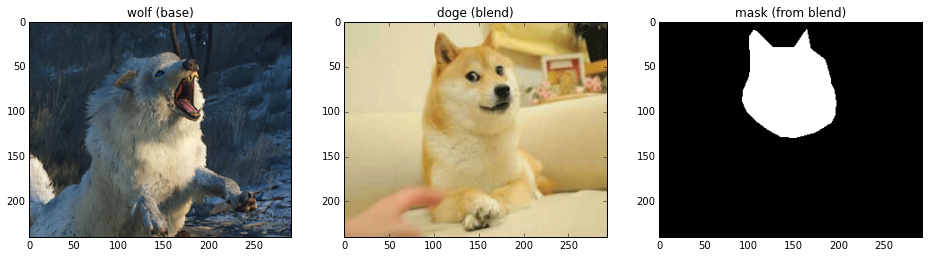

In [3]:
#LOAD IMAGES
doge = io.imread("./img/doge.png")
wolf = io.imread("./img/wolf.png")
mask = io.imread("./img/mask.png")

# Borked the binarization when creating the mask.
# Too lazy to fix it in Photoshop.
mask[mask < 255] = 0

plt.subplot(1,3,1)
plt.imshow(wolf)
plt.title('wolf (base)')
plt.subplot(1,3,2)
plt.imshow(doge)
plt.title('doge (blend)')
plt.subplot(1,3,3)
plt.imshow(mask, cmap = 'gray')
plt.title('mask (from blend)')
plt.gcf().set_size_inches((16,9))

In [4]:
print 'doge', doge.shape
print 'wolf', wolf.shape
print 'mask', mask.shape

print mask[0][0]
print mask[75][150]

doge (240L, 293L, 3L)
wolf (240L, 293L, 3L)
mask (240L, 293L)
0
255


In [65]:
def do_poisson_blending(base, blend, mask, iterations = 1000):
    def is_masked(x, y):
        return mask[y][x] == 255
    
    def colour(img, x, y, channel):
        return img[y][x][channel]
    
    result = np.zeros(shape = base.shape, dtype = np.float)
    previous_epsilon = 1.0
    cnt = 0
    
    # Fill the result image with all pixels from base and to
    # be blended image.
    
    # Also, a little optimization so that I can loop over masked
    # pixels only, instead of looping over all pixels from
    # base image
    masked_pixels = []
    width, height = base.shape[1], base.shape[0]
    for y in xrange(1, height - 1):
        for x in xrange(1, width -1):
            if is_masked(x, y):
                result[y][x] = blend[y][x]
                masked_pixels.append((y, x))
            else:
                result[y][x] = base[y][x]
    
    while True:
        dx = 0
        absx = 0
        for y, x in iter(masked_pixels):
        # for y in xrange(1, height - 1):
        #     for x in xrange(1, width -1):
        #         if is_masked(x, y):
                    q = [(y-1, x), (y+1, x), (y, x-1), (y, x+1)]
                    # cs = [0.0] * 3
                    # cd = [0] * 3
                    
                    for c in xrange(3):
                        sum_fq = 0
                        sum_vpq = 0
                        sum_boundary = 0
                        
                        for qy, qx in q:
                            if is_masked(qx, qy):
                                sum_fq += result[qy][qx][c]
                            else:
                                sum_boundary += base[qy][qx][c]

                            if abs(base[y][x][c] - base[qy][qx][c]) > abs(blend[y][x][c] - blend[qy][qx][c]):
                                sum_vpq += ( base[y][x][c] - base[qy][qx][c] )
                            else:
                                sum_vpq += ( blend[y][x][c] - blend[qy][qx][c] )
                        
                        new_value = ( sum_fq + sum_vpq + sum_boundary ) / 4.0 # float(len(q))
                        
                        # print x, y, c, sum_fq, sum_vpq, sum_boundary, new_value
                        
                        dx += abs(new_value - result[y][x][c])
                        absx += abs(new_value)
                        
                        result[y][x][c] = new_value
                        # cs[c] = new_value
                        # cd[c] = result[y][x][c]
                    
                    # print x, y, cs, cd, base[y][x], blend[y][x]
        cnt += 1
        epsilon = dx / absx
        if ( previous_epsilon - epsilon ) == 0.0 or cnt >= iterations:
            break
        else:
            previous_epsilon = epsilon
    print cnt
    print type(result)
    print previous_epsilon, epsilon
    return result

200
<type 'numpy.ndarray'>
0.000573671454818 0.000571556620552


<matplotlib.colorbar.Colorbar instance at 0x000000001AB4AE48>

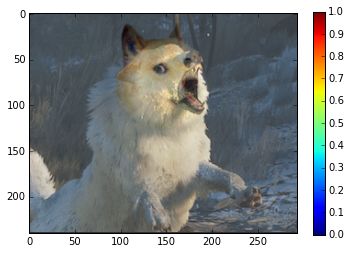

In [67]:
f_wolf = wolf / 255.
f_doge = doge / 255.

result = do_poisson_blending(f_wolf, f_doge, mask, iterations = 200)

# Put values between 0 and 1
result2 = ( result - np.min(result) ) / ( np.max(result) - np.min(result) )

plt.imshow(result2)
plt.colorbar()

In [76]:
print result[75][150]

[115  62 216]
